In [1]:
import pandas as pd
import pymysql 
from functools import reduce
import numpy as np
import textstat
import nltk
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import random

In [2]:
df = pd.read_csv("./my_all_data.csv")
df.head()

,custom_id,title_tag_1,title_tag_2,title_tag_3,title_tag_4,title_tag_5,title_tag_6,title_tag_7,title_tag_8,title_tag_9,...,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_desc_6,svd_desc_7,svd_desc_8,svd_desc_9,svd_desc_10
0,0,1.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.14750,0.02840,-0.00829,-0.012856,-0.028960,-0.069640,-0.007347,0.031250,-0.006620,0.013466
1,0,0.0,0.3333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.12770,0.09625,0.00669,-0.034580,0.013150,-0.070400,0.031920,-0.003273,0.004753,-0.031800
2,0,0.0,0.2000,0.0,0.0,0.2,0.0,0.0,0.0,0.0,...,0.10394,0.06433,-0.02425,-0.037800,-0.012405,-0.019040,-0.000008,-0.020750,0.012240,-0.015720
3,0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.11676,0.10486,-0.03525,-0.060970,-0.006680,-0.028980,0.007374,-0.022870,-0.014260,-0.041200
4,0,0.0,1.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04626,0.02815,-0.01048,-0.011950,-0.008310,0.001104,-0.038120,-0.021700,-0.002910,0.004173


In [3]:
## train-valid-test split, 80 items for traning, 5 items for validaiton, 15 items for testing.
train_x = df[0:170000].drop(['custom_id'],axis=1)  #80->170
train_y = df['custom_id'][0:170000].values
val_x = df[170000:180000].drop(['custom_id'],axis=1)  #5->10
val_y = df['custom_id'][170000:180000].values
test_x = df[180000:200000].drop(['custom_id'],axis=1) #15->20
test_y = df['custom_id'][180000:200000].values

In [4]:
params = {
        "objective" : "multiclass",
        "metric" : "multi_logloss",
        'boosting_type': 'gbdt',
        'num_class' : 1000,
        'max_bin' : 255,
        'metric_freq' : 5,
        "is_training_metric" : 'true',
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_freq" : 5,
        "bagging_seed" : 2018,
        "verbosity" : 1,
        'device': 'cpu',    
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

In [5]:
import lightgbm as lgb
def run_lgb(train_x, train_y, val_x, val_y ,test_x):
    print(train_x.shape, val_x.shape, test_x.shape)
    lgtrain = lgb.Dataset(train_x, label=train_y)
    lgval = lgb.Dataset(val_x, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 3000, valid_sets=[lgval], early_stopping_rounds=7, verbose_eval=20, evals_result=evals_result)   
    pred_test_y = model.predict(test_x, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result
pred_test, model, evals_result = run_lgb(train_x, train_y, val_x, val_y, test_x)
print("Done!")

(170000, 129) (10000, 129) (20000, 129)
Training until validation scores don't improve for 7 rounds.
[20]	valid_0's multi_logloss: 5.60471
[40]	valid_0's multi_logloss: 5.22214
[60]	valid_0's multi_logloss: 4.9687
[80]	valid_0's multi_logloss: 4.77403
[100]	valid_0's multi_logloss: 4.61448
[120]	valid_0's multi_logloss: 4.47902
[140]	valid_0's multi_logloss: 4.36036
[160]	valid_0's multi_logloss: 4.25525
[180]	valid_0's multi_logloss: 4.16016
[200]	valid_0's multi_logloss: 4.07365
[220]	valid_0's multi_logloss: 3.9947
[240]	valid_0's multi_logloss: 3.92147
[260]	valid_0's multi_logloss: 3.8542
[280]	valid_0's multi_logloss: 3.79162
[300]	valid_0's multi_logloss: 3.73376
[320]	valid_0's multi_logloss: 3.67971
[340]	valid_0's multi_logloss: 3.62901
[360]	valid_0's multi_logloss: 3.58174
[380]	valid_0's multi_logloss: 3.53711
[400]	valid_0's multi_logloss: 3.49525
[420]	valid_0's multi_logloss: 3.45615
[440]	valid_0's multi_logloss: 3.41916
[460]	valid_0's multi_logloss: 3.3838
[480]	vali

In [6]:
## caculate the test rank1 accuracy:
print(pred_test.shape)
test_num = len(test_y)
right_num = 0
test_result = []
for i in range(test_num):
    test_result.append(pred_test[i].tolist().index(max(pred_test[i])))
    if test_result[i] == test_y[i]:
        right_num +=1
rank1_acc = right_num/test_num
print("rank1 accuracy is:",rank1_acc)

(20000, 1000)
rank1 accuracy is: 0.4382


In [7]:
## compute F1 score
from sklearn.metrics import f1_score
f1_ma = f1_score(test_y, test_result, average='macro')  
f1_mi = f1_score(test_y, test_result, average='micro')  
f1_we = f1_score(test_y, test_result, average='weighted')  
print("F1 macro:",f1_ma,";F1 micro:",f1_mi,"F1 weighted:",f1_we)

F1 macro: 0.4410346581638661 ;F1 micro: 0.4382 F1 weighted: 0.44103465816386617


In [8]:
## calculate collective-vote rank1 accuracy
num_per_author=20
from scipy import stats
right_num = 0
for i in range(int(test_num/num_per_author)):
    ten_out=[]
    for j in range(num_per_author):
        ten_out.append(pred_test[i*num_per_author+j].tolist().index(max(pred_test[i*num_per_author+j])))
    if stats.mode(ten_out)[0][0] == test_y[i*num_per_author+j]:
        right_num +=1
ten_vote_acc = right_num*num_per_author/test_num
print("20 vote rank1 accuracy is:",ten_vote_acc)

20 vote rank1 accuracy is: 0.962


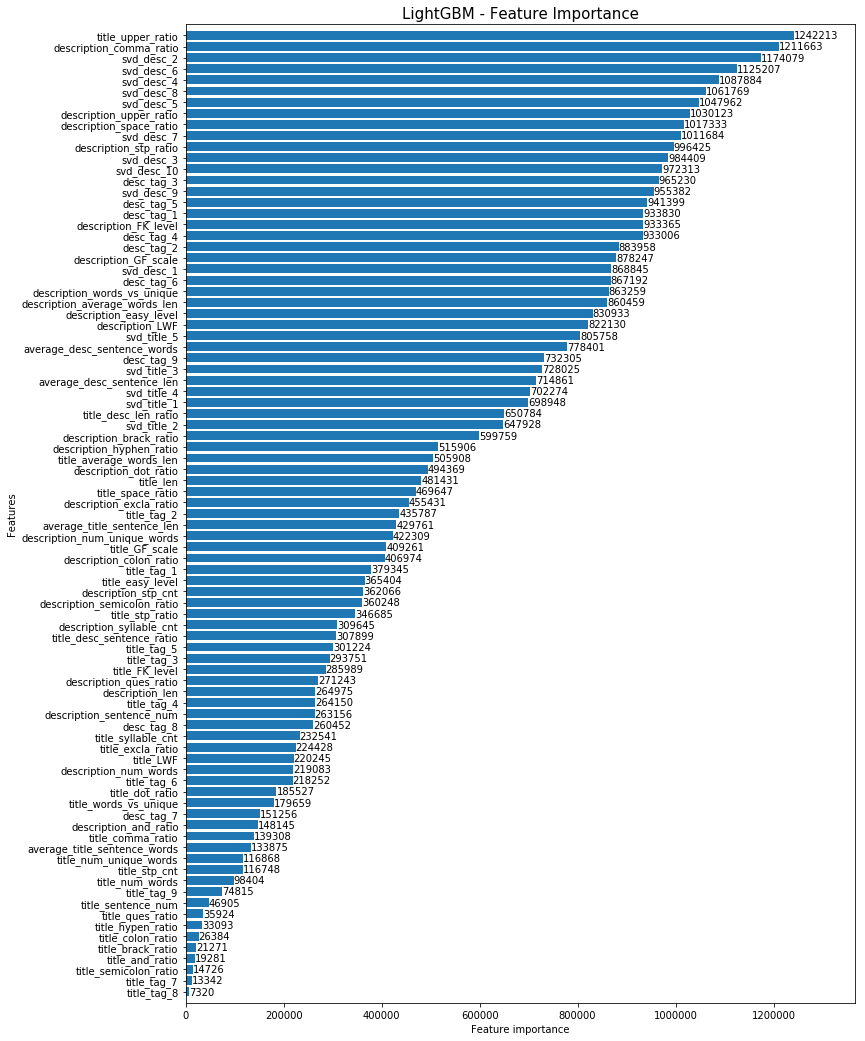

In [9]:
#show LGBM feature importance map
import matplotlib.pyplot as plt
%matplotlib inline  
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()